<a href="https://colab.research.google.com/github/Boul-code/Forecasting/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Non Seasonal Time Series Analysis

---
> D22125166 Alexandre BOUL

> D22125080 Aurélien Lecamus
---



### **Summary**
*   Dataset source : https://www.kaggle.com/datasets/nicklitwinow/population-by-country
*   1- Goal of the project 
*   2- Data preprocessing
*   3- Test ADF
*   4- Checking stationnarity
*   5- The ARIMA Model
*   6- Forecasting
*   Conclusion
-------------------------------------------------------------------------

##Nonseasonal data

>The data set used includes the population in France for each year since year 0. Allowing you to study several things. However, there is a lot of missing data for the earlier years and in order to have a more interesting analysis, I have chosen to only keep the data after 1900 in my analysis. I chose this data because I find it interesting to see the evolution of the French population, perhaps to estimate the population in the future, or to analyze the evolution of this population. The link to the dataset can be found below.

https://www.kaggle.com/datasets/nicklitwinow/population-by-country


### Data preprocessing


In [1]:
#Import the required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data loading in a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/Boul-code/Forecasting/main/Population.csv', sep=',', usecols = ['Year', 'France'])
#Dhow top records in the df
df.head()

,Year,France
0,1.0,"5,000"
1,730.0,NaN
2,1000.0,"6,500"
3,1090.0,NaN
4,1150.0,NaN


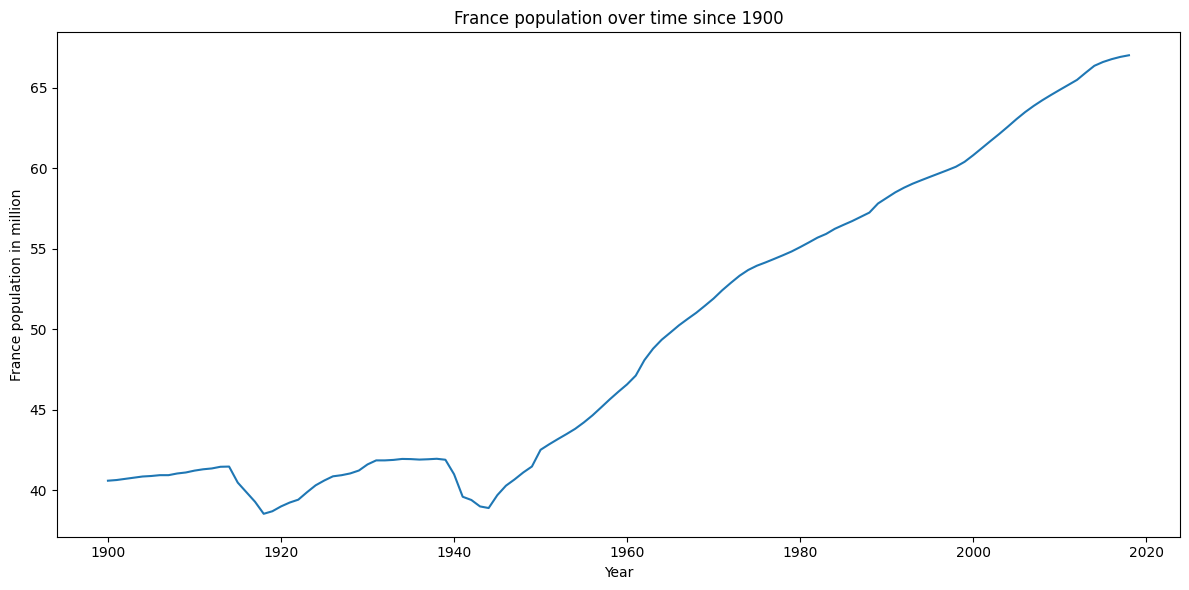

In [3]:
df['France'] = df['France'].astype(str).str.replace(',', '.').astype(float)

# Filter the dataframe to only include data from 1900 onwards
df = df.loc[df['Year'] >= 1900]
#Create the figure and axis objects
fig, ax = plt.subplots()

#Plot the data on the axis
ax.plot(df['Year'], df['France'])

#Add labels and a title
ax.set_xlabel('Year')
ax.set_ylabel('France population in million')
ax.set_title('France population over time since 1900')


#Enlarge the figure
fig.set_size_inches(12, 6)

#Show the figure
plt.tight_layout()
plt.show()

We can observe two dips in this graph, and it's quite easy to understand that they are due to the two world wars. Just after the Second World War, we can see a clear increase in population, mainly due to a period called the "Les 30 glorieuses".

## Test ADF


In [4]:
ADF_result = adfuller(df['France'])

# Print the ADF statistic obtained from the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

#Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')
# Extract the critical values at different significance levels
critical_values = ADF_result[4]
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

ADF Statistic: 1.0719285520472872
p-value: 0.9949697779162013
Critical Values:
	1%: -3.489057523907491
	5%: -2.887246327182993
	10%: -2.5804808802708528


> This results in an ADF statistic of 1.07 and a p-value of 0.99. Here, the ADF statistic is not a small negative number, and the p-value is larger than 0.05. Therefore, our time series is not stationary, and we must apply transformations to make it stationary.


## Checking stationnarity



ADF Statistic: -3.9020531500461075
p-value: 0.0020197889032956082
Critical Values:
	1%: -3.489057523907491
	5%: -2.887246327182993
	10%: -2.5804808802708528


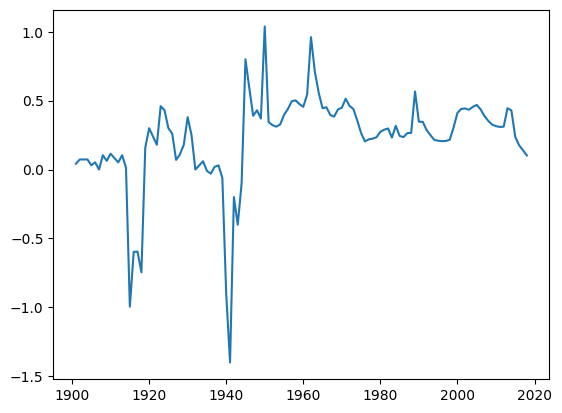

In [5]:
fig, ax = plt.subplots()

# Calculate the difference between consecutive values in the 'France' column of the 'df' DataFrame using np.diff
france_diff = np.diff(df['France'], n=1)
# Create an array of values from the 'Year' column of the 'df' DataFrame
date_array_two = df['Year'].values
# Remove the first value from the 'date_array_two' array
date_array_two = date_array_two[1:]

# Perform the Augmented Dickey-Fuller (ADF) test on the 'france_diff' array using the adfuller function from the statsmodels library
ADF_result = adfuller(france_diff)

# Print the ADF test statistic obtained from the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

# Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')
# Extract the critical values at different significance levels
critical_values = ADF_result[4]
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")
ax.plot(date_array_two, france_diff)

> This results in an ADF statistic of -3.9 and a p-value of 0.002. Here, the ADF statistic is a large negative number, and the p-value is smaller than 0.05. Therefore, our time series is stationary, and we don't need to apply another transformations to make it stationary.


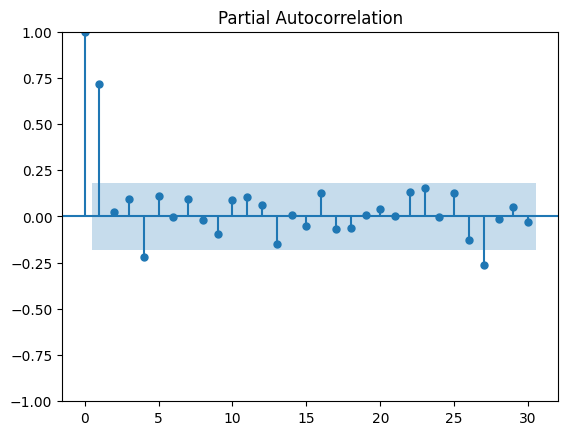

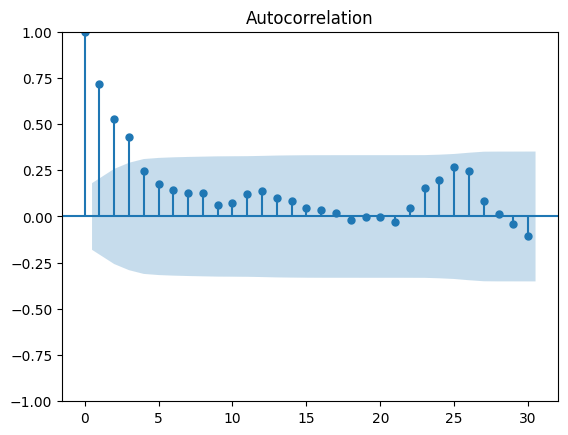

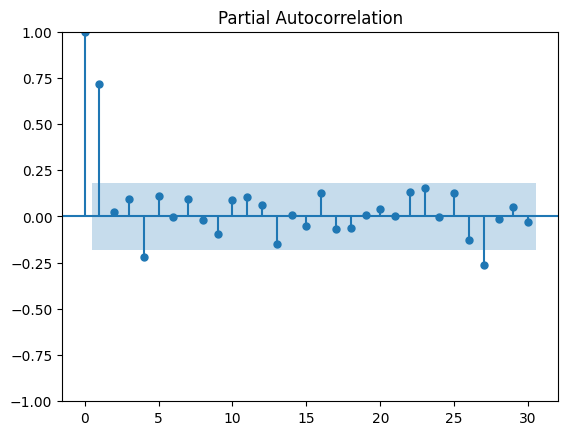

In [6]:
# Plot the autocorrelation function (ACF) of the 'france_diff' array up to 30 lags using the plot_acf function from the statsmodels library
plot_acf(france_diff, lags=30)
# Plot the partial autocorrelation function (PACF) of the 'france_diff' array up to 30 lags using the plot_pacf function from the statsmodels library
plot_pacf(france_diff, lags=30, method='ywm')

> We can deduce with the autocorrelation that we have an AR(2) process model.

## The ARIMA model



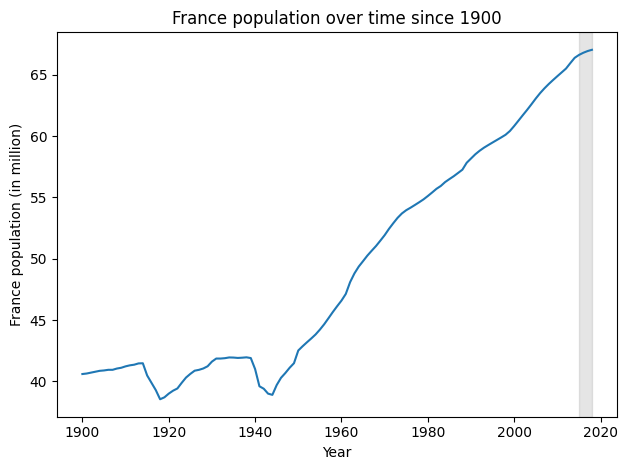

In [7]:
fig, ax = plt.subplots()
df = df.loc[df['Year'] >= 1900]
#Plot the data on the axis
ax.plot(df['Year'], df['France'])

#Add labels and a title
ax.set_xlabel('Year')
ax.set_ylabel('France population (in million)')
ax.set_title('France population over time since 1900')
ax.axvspan(2015, 2018, color='#808080', alpha=0.2)

#Show the figure
plt.tight_layout()


We then define a list of possible values for the orders p and q with the Arima Order List.

In [8]:
# Define two ranges from 0 to 3 (inclusive) with a step size of 1
ps = range(0, 4, 1)
qs = range(0, 4, 1)

# Define a variable with a value of 2 (not used in the rest of the code)
d = 2

# Use the product() function from the itertools module to create a list of all possible ordered pairs of elements from ps and qs
order_list = list(product(ps, qs))

To fit the many ARIMA(p,d,q) models, we’ll define the optimize_ARIMA function. It will fit the different models and order them by ascending AIC in order to select the model with the lowest AIC. Note that we do not give a range of values for the parameter d because it has a very specific definition: it is the number of times a series must be differenced to become stationary. Hence, it must be set to a specific value, which in this case is 1.

In [9]:
# Function definition with training_data (time series data), order_list (list of tuples of ARIMA orders to test), and d (order of differencing) as input parameters
def optimize_ARIMA(training_data, order_list, d) -> pd.DataFrame:
    
    # Initialize an empty list to store results
    results = []
    
    # Iterate over all ARIMA orders in the order_list using tqdm_notebook for progress tracking
    for order in tqdm_notebook(order_list):
        try: 
            # Fit an ARIMA model with SARIMAX from statsmodels using the current ARIMA order and input training data
            model = SARIMAX(training_data, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            # If the model cannot be fit (e.g., due to numerical instability), skip to the next order
            continue
            
        # Compute the AIC and BIC metrics for the fitted model
        aic = model.aic
        bic = model.bic
        
        # Store the order, AIC, and BIC values in the results list as a nested list
        results.append([order, aic, bic])
        
    # Convert the results list to a pandas DataFrame and assign column names
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC', 'BIC']
    
    # Sort the DataFrame in ascending order by AIC and reset the index
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    # Return the sorted results DataFrame
    return result_df

# Select data from 1900 onwards, convert the Year column to datetime format, set it as the index, and set the frequency to yearly start
df = df.loc[df['Year'] >= 1900]
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
df.index.freq = 'YS'

# Select the time series data for France from the input DataFrame and store it as a variable train
train = df['France']

# Call the optimize_ARIMA function with the input time series data, order_list, and differencing order as arguments, and store the resulting DataFrame in result_df
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC,BIC
0,"(1, 1)",-2.137962,6.148559
1,"(3, 3)",-1.753686,17.581532
2,"(3, 2)",-1.522300,15.050743
3,"(2, 2)",-0.840399,12.970471
4,"(2, 3)",-0.293650,16.279393
5,"(0, 2)",3.177833,11.464354
6,"(2, 1)",3.514906,14.563601
7,"(1, 2)",4.039238,15.087934
8,"(0, 3)",5.134156,16.182851
9,"(3, 1)",5.390403,19.201273


We will keep the value 1 and 1 for p and q value, in fact it is for this case that the AIC is the lowest.

In [10]:
# Import the SARIMAX class from the statsmodels library
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit an ARIMA model with p=1, d=1, and q=1 to the input time series data train
# Set simple_differencing to False to use the exact differencing method
model = SARIMAX(train, order=(1, 1, 1), simple_differencing=False)

# Fit the model to the input data and obtain the model summary
# Set disp to False to suppress output of the optimization routine
model_fit = model.fit(disp=False)

# Print the model summary to the console
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 France   No. Observations:                  119
Model:               SARIMAX(1, 1, 1)   Log Likelihood                   2.681
Date:                Mon, 08 May 2023   AIC                              0.637
Time:                        22:11:12   BIC                              8.950
Sample:                    01-01-1900   HQIC                             4.012
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8405      0.074     11.355      0.000       0.695       0.986
ma.L1         -0.1133      0.115     -0.983      0.326      -0.339       0.113
sigma2         0.0555      0.004     14.813      0.0

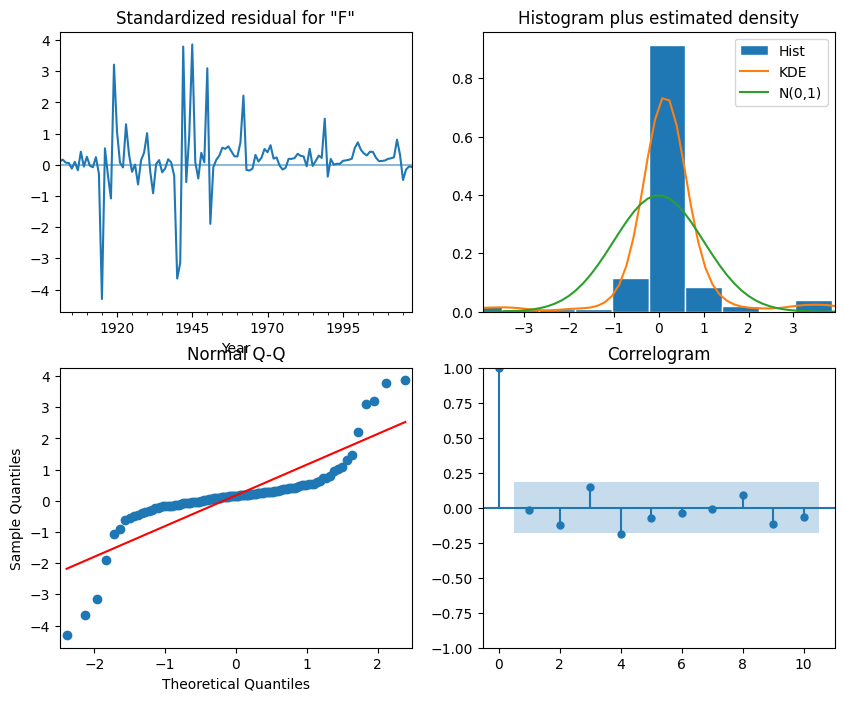

In [11]:
# Plot diagnostic plots of the model fit
# figsize sets the size of the figure to (10, 8) inches
model_fit.plot_diagnostics(figsize=(10,8));

*  The top-left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise.

*  The top-right plot shows the distribution of the residuals. We can see it is fairly close to a normal distribution. 

*  The Q-Q plot leads us to the same conclusion, as it displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution.

*  Finally, by looking at the correlogram at the bottom right, we can see that a coefficient seems to be significant at lag 4. However, since it is not preceded by any significant autocorrelation coefficients, we can assume that this is due to chance. 


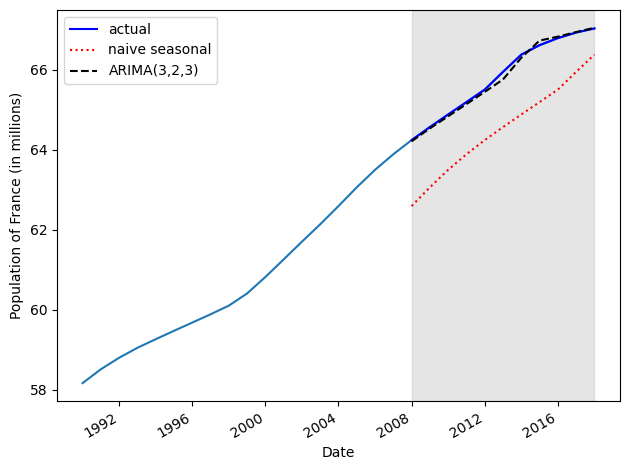

In [12]:
# Slice the input time series data between 2008-01-01 and 2018-01-01 and store it in the variable 'test'
test = df.loc['2008-01-01':'2018-01-01'] 

# Create a new column in 'test' called 'naive_seasonal' and fill it with the values of 'France' between 2004-01-01 and 2014-01-01
test.loc[:, 'naive_seasonal'] = df['France'].loc['2004-01-01':'2014-01-01'].values

# Obtain the predicted values of the ARIMA model between 2008-01-01 and 2018-01-01 and store them in the variable 'ARIMA_pred'
ARIMA_pred = model_fit.get_prediction('2008-01-01', '2018-01-01').predicted_mean

# Add a new column to 'test' called 'ARIMA_pred' and fill it with the values of 'ARIMA_pred'
test['ARIMA_pred'] = ARIMA_pred

# Create a new figure and axes object
fig, ax = plt.subplots()

# Slice the input time series data between 1990-01-01 and the end of the time series and store it in the variable 'df'
df = df.loc[df.index >= '1990-01-01']

# Plot the entire time series on the axes
ax.plot(df.index, df['France'])

# Plot the 'France' values of 'test' as a blue solid line with label 'actual'
ax.plot(test['France'], 'b-', label='actual')

# Plot the 'naive_seasonal' values of 'test' as a red dotted line with label 'naive seasonal'
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')

# Plot the 'ARIMA_pred' values of 'test' as a black dashed line with label 'ARIMA(3,2,3)'
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

# Set the x-axis label to 'Date' and the y-axis label to 'Population of France (in millions)'
ax.set_xlabel('Date')
ax.set_ylabel('Population of France (in millions)')

# Shade the area between 2008-01-01 and 2018-01-01 with a light gray color
ax.axvspan('2008-01-01', '2018-01-01', color='#808080', alpha=0.2)

# Add a legend to the plot with the labels defined earlier
ax.legend(loc=2)

# Automatically adjust the x-axis tick labels to prevent overlapping
fig.autofmt_xdate()

# Adjust the spacing of the subplots to prevent overlap
plt.tight_layout()



We can see the naive seasonal forecast as a dotted line and the ARIMA(1,1,1) forecasts as a dashed line. The ARIMA(1,1,1) model predicted the population with a very small error.
We can quantify that error by measuring the mean absolute percentage error
(MAPE) and display the metric for each forecasting method in a bar plot, as shown in the next step.

In [13]:
#Import the mean absolute percentage error function from the scikit-learn library
from sklearn.metrics import mean_absolute_percentage_error as mape

#Calculate the MAPE for the Naive Seasonal method using the test data
mape_naive_seasonal = mape(test['France'], test['naive_seasonal'])*100

#Calculate the MAPE for the ARIMA method using the test data
mape_ARIMA = mape(test['France'], test['ARIMA_pred'])*100

#Print the MAPE values for both methods
print('MAPE Naive:',"%.2f" % (mape_naive_seasonal),'%')
print('MAPE ARIMA:',"%.2f" % (mape_ARIMA),'%')

MAPE Naive: 1.98 %
MAPE ARIMA: 0.09 %


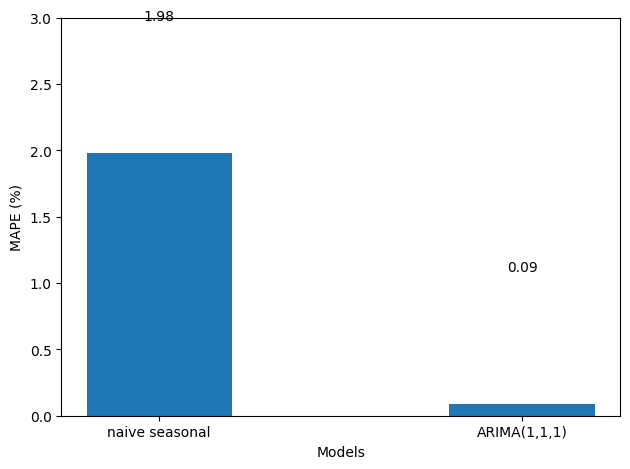

In [14]:
#Create a bar chart with two models and their corresponding MAPEs
fig, ax = plt.subplots()

#Define the x and y values
x = ['naive seasonal', 'ARIMA(1,1,1)']
y = [mape_naive_seasonal, mape_ARIMA]

#Create the bar plot
ax.bar(x, y, width=0.4)

#Add x and y labels
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

#Set the y-axis limit to 0-3
ax.set_ylim(0, 3)

#Add text labels to each bar
for index, value in enumerate(y):
  plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

#Adjust the layout and display the plot
plt.tight_layout()

You can see that the MAPE for the naive seasonal forecast is 1.98%,
while the MAPE for the ARIMA(1,1,1) model is 0.09%. This means that our predictions are on average 0.09% off from the actual values. The ARIMA(1,1,1) model is clearly a better model than the naive seasonal method.

## Forecasting

Now that our model is good, we can try to predict the French population for the next 10 years.

In [15]:
#Import the SARIMAX model from the statsmodels library
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Create a SARIMAX model with specified order (p,d,q) and set simple_differencing to False
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)

#Fit the model to the training data
model_fit = model.fit(disp=False)

#Generate a forecast for the next 10 time steps using the trained model
forecast = model_fit.forecast(steps=10)

In [16]:
#Create a date range from 2019 to 2029 with a frequency of yearly
dates = pd.date_range(start='2019', end='2029', freq='Y')

#Create a new pandas DataFrame with the predicted population values and corresponding date
df_predictions = pd.DataFrame({'population': forecast, 'date': dates})

#Add a new column to the DataFrame with the year extracted from the date column using a lambda function
df_predictions['year'] = df_predictions['date'].apply(lambda x: x.year)

#Drop the date column from the DataFrame as it is no longer needed
df_predictions.drop('date', axis=1, inplace=True)

#The resulting DataFrame contains the predicted population values and the corresponding year for each prediction

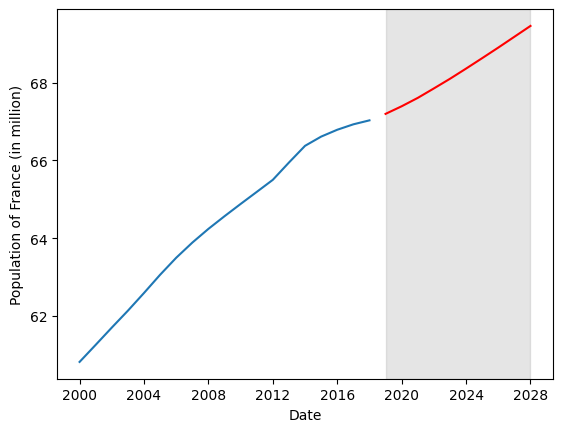

In [17]:
#Import the matplotlib library and create a new figure and axis object
fig, ax = plt.subplots()

#Filter the original DataFrame to only include dates starting from January 1, 2000
df = df.loc[df.index >= '2000-01-01']

#Plot the population of France over time using the original data
ax.plot(df.index, df['France'])

#Plot the predicted population of France over time using the forecast DataFrame and a red solid line
ax.plot(df_predictions.index, df_predictions['population'], 'r-', label='predicted')

#Set the x-axis label to "Date" and the y-axis label to "Population of France (in million)"
ax.set_xlabel('Date')
ax.set_ylabel('Population of France (in million)')

#Add a vertical span between January 1, 2019 and January 1, 2028 to highlight the predicted period
ax.axvspan('2019-01-01', '2028-01-01', color='#808080', alpha=0.2)

On this graph, you can find the prediction of the population in France up until 2028. As we can see on the graph, especially from 2018 to 2023, which are years for which we have knowledge of the population in France (but which are not in our dataset), the values are very close to reality. This correlates with the low MAPE of the ARIMA model.

## Conclusion

---

In conclusion, we have accurate predictions for the number of inhabitants in France for the next five years. These predictions allow us to estimate the French population and, most importantly, observe that its evolution continues fairly linearly. This could help make decisions, whether they are political or for businesses.